In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import poisson, nbinom

# === CONFIGURAÇÃO GERAL ===
TOTAL_DIAS = 80  # Total de dias da simulação
INFECTADOS_INICIAIS = 1  # Número de infectados no início
NUM_SIMULACOES = 50  # Número de simulações independentes
DIA_INTERVENCAO = 20  # Novo dia de intervenção (mais cedo para controlar o surto)

MAX_INFECTADOS = 4000  # Limite máximo de infectados para permitir crescimento natural

# === PARÂMETROS EPIDEMIOLÓGICOS ===
# Antes da intervenção
Rt_antes = 3.2  # Taxa de reprodução antes da intervenção (ajustado)
muT_antes = 4.0  # Tempo médio entre infecções
sizeV_antes = 1.0  # Parâmetro de dispersão antes da intervenção

# Depois da intervenção
Rt_depois = 0.8  # Taxa de reprodução depois da intervenção
muT_depois = 4.0  # Tempo médio entre infecções (mantido)
sizeV_depois = 0.6  # Parâmetro de dispersão depois da intervenção

# === FUNÇÃO DE SIMULAÇÃO ===
def simular_cenario(com_intervencao=False):
    casos_ativos_por_dia = np.zeros(TOTAL_DIAS)  # Vetor para armazenar o número de casos ativos por dia
    lista_infectados = []

    # Infectados iniciais
    for _ in range(INFECTADOS_INICIAIS):
        lista_infectados.append({
            'dia_infeccao': 0,
            'dias_recuperacao': random.randint(10, 15)  # Tempo de recuperação inicial
        })

    # Simulação dia a dia
    for dia in range(TOTAL_DIAS):
        novos_infectados = []

        # Para cada infectado ativo
        for infectado in lista_infectados:
            if infectado['dia_infeccao'] == dia:
                # Definir parâmetros conforme intervenção
                if com_intervencao and dia >= DIA_INTERVENCAO:
                    Rt = Rt_depois
                    muT = muT_depois
                    sizeV = sizeV_depois
                else:
                    Rt = Rt_antes
                    muT = muT_antes
                    sizeV = sizeV_antes

                # Número de novos infectados gerados por este infectado
                num_novos_infectados = poisson.rvs(Rt)

                for _ in range(num_novos_infectados):
                    # Em quantos dias ocorrerá a nova infecção
                    dias_ate_infeccao = nbinom.rvs(sizeV, sizeV / (sizeV + muT))
                    dia_nova_infeccao = dia + dias_ate_infeccao

                    if dia_nova_infeccao < TOTAL_DIAS:
                        # Tempo de recuperação varia conforme intervenção
                        if com_intervencao and dia >= DIA_INTERVENCAO:
                            dias_recuperacao = random.randint(4, 6)
                        else:
                            dias_recuperacao = random.randint(10, 15)

                        if len(lista_infectados) + len(novos_infectados) < MAX_INFECTADOS:
                            novos_infectados.append({
                                'dia_infeccao': dia_nova_infeccao,
                                'dias_recuperacao': dias_recuperacao
                            })

        lista_infectados.extend(novos_infectados)

        # Calcular número de casos ativos no dia atual
        casos_ativos_hoje = sum(1 for infectado in lista_infectados if infectado['dia_infeccao'] <= dia < infectado['dia_infeccao'] + infectado['dias_recuperacao'])
        casos_ativos_por_dia[dia] = casos_ativos_hoje

    return casos_ativos_por_dia

# === EXECUTAR SIMULAÇÕES ===
np.random.seed(42)
random.seed(42)

simulacoes_sem_intervencao = np.zeros((NUM_SIMULACOES, TOTAL_DIAS))
simulacoes_com_intervencao = np.zeros((NUM_SIMULACOES, TOTAL_DIAS))

for i in range(NUM_SIMULACOES):
    simulacoes_sem_intervencao[i, :] = simular_cenario(com_intervencao=False)
    simulacoes_com_intervencao[i, :] = simular_cenario(com_intervencao=True)

# === CALCULAR MÉDIAS ===
media_sem_intervencao = np.mean(simulacoes_sem_intervencao, axis=0)
media_com_intervencao = np.mean(simulacoes_com_intervencao, axis=0)


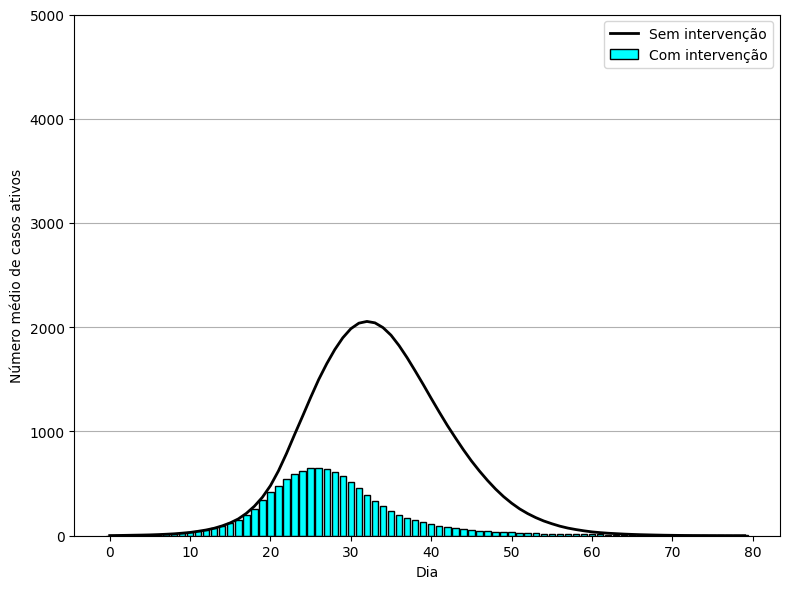

In [ ]:
# === GERAR GRÁFICO ===
plt.figure(figsize=(8, 6))
plt.bar(np.arange(TOTAL_DIAS), media_com_intervencao, color='cyan', edgecolor='black', label='Com intervenção')
plt.plot(media_sem_intervencao, color='black', linewidth=2, label='Sem intervenção')
plt.xlabel('Dia')
plt.ylabel('Número médio de casos ativos')
plt.legend()
plt.grid(axis='y')
plt.ylim(0, 5000)  # Escala fixa no eixo Y entre 0 e 5000
plt.tight_layout()
plt.show()
